# DEMO2 Multitask learning
- In this demo, we would like to allow a ML model to learn both "PEDOT-PSS" and "Wikipedia" databases
    - in the manuscript, totally 14 databases were used for training.
        - some of them cannot be uploaded due to the copyright issue.
        - therefore, wikipedia database is used for multitask training in this DEMO.
    - you can add your favorite databases to improve prediction accuracy, etc.
- Basic steps are the same as DEMO1

## This script will format graph databases


In [1]:
import sys
sys.path.append("../MIGraph/GraphConv/")

from ValueTransformer import ValueTransformer
from ConvGraphScript import drawGraph,checkGraphList
from AutoParameterScaling import AutoParameterScaling
from ConvGraphmlToGraph import loadGraphCSV
from PrepGraphScript import PrepGraphScript

import glob
import os
import joblib
from tqdm import tqdm
import numpy as np
import random

os.chdir("praparingGraphs")


In [2]:
#load PEDOT-PSS files
folderList=glob.glob("input/PEDOTPSS/*")

CSVPathList=[]
graphPathList=[]

for folder in folderList:
    CSVPath=folder+"/"+os.path.basename(folder)+".csv"
    graphPath=folder+"/graph/"
    CSVPathList.append(CSVPath)
    graphPathList.append(graphPath)

# convert graph-type PEDOT-PSS file
- In DEMO1, graph-shaped PEDOT-PSS database was made automatically by NLP.
- However, we made graph databases manually here, because the connection styles in graphs ("formats") were different from our "standard format". (compare those graphs, if you want)
- Graphs are recorded in a graphml format.

In [3]:
VT=ValueTransformer()
for CSVPath,graphPath in zip(CSVPathList,graphPathList):
    print(CSVPath)
    gList=loadGraphCSV(CSVPath,graphPath)

    #convert unit etc
    gList=VT.convertGraphList(gList)
    checkGraphList(gList)
    
    filename=os.path.basename(CSVPath)
    outname="temporary/"+filename+".graphbin"
    print("saving...", outname)
    joblib.dump(gList,outname,compress=3)
    

100%|██████████| 340/340 [00:00<00:00, 656.43it/s]
checking graph values...
check done
saving... temporary/20200220PEDOTProcess.csv.graphbin


# convert wikipedia database
- the database is recorded as a table.
- it will be converted to graphs

In [4]:
#convert wikipedia file
#you can add other compound csv files in additional_simple_comps
csvList=glob.glob("input/additional_simple_comps/*.csv")
print(len(csvList))
sorted(csvList)


def conv(filename):
    pgs=PrepGraphScript(filename)
    pgs.doFragment=False
    pgs.prapareGraphList(numOfMaxFragments=2000)

for num,filename in tqdm(enumerate(csvList)):
    print(num, "file: ",filename)
    conv(filename)

0it [00:00, ?it/s]
  1%|          | 10/1370 [00:00<00:14, 92.89it/s]1
0 file:  input/additional_simple_comps/20190520wikipedia.csv

100%|██████████| 1370/1370 [00:14<00:00, 91.54it/s]
checking graph values...
caution: too large val:  3090.0 graph No.:  1
caution: too large val:  2400.0 graph No.:  2
caution: too large val:  2797.0 graph No.:  4
caution: too large val:  2865.0 graph No.:  5
caution: too large val:  2160.0 graph No.:  8
caution: too large val:  1890.0 graph No.:  9
caution: too large val:  1872.0 graph No.:  12
caution: too large val:  2400.0 graph No.:  18
caution: too large val:  3500.0 graph No.:  18
caution: too large val:  1910.0 graph No.:  21
caution: too large val:  1955.0 graph No.:  30
caution: too large val:  2315.0 graph No.:  33
caution: too large val:  4200.0 graph No.:  33
caution: too large val:  2183.0 graph No.:  34
caution: too large val:  3760.0 graph No.:  34
caution: too large val:  1900.0 graph No.:  38
caution: too large val:  1748.0 graph No.:  3

# combine compound databases

In [5]:
import pandas as pd
#in the case of this PEDOT-PSS_txt project, only one compound file is available, but normally many)
allCompundsPath="output/allcompounds.csv.gz"

csvList=glob.glob("../convCSVtoGraph/temp/output/*.csv")
csvList2=glob.glob("input/*.csv")
csvgzList=glob.glob("input/*.csv.gz")

compPathList=sorted(list(set(csvList)|set(csvgzList)|set(csvList2)))
print(compPathList)

['input/20190520wikipedia.csv.gz', 'input/20200220PEDOTProcess_comp.csv']


In [6]:
CompColumns=["ID","SMILES"]

for num,filePath in enumerate(compPathList):
    print(filePath)
    if num==0:
        df=pd.read_csv(filePath)[CompColumns]
    else:
        df2=pd.read_csv(filePath)[CompColumns]
        df=pd.concat([df,df2],axis=0)
        
df=df.drop_duplicates("ID")
df=df[CompColumns].reset_index()
df.to_csv(allCompundsPath,index=False)
df

input/20190520wikipedia.csv.gz
input/20200220PEDOTProcess_comp.csv


,index,ID,SMILES
0,0,[Cd]=[Te],[Cd]=[Te]
1,1,N#[Ta],N#[Ta]
2,2,B#[Re]#B,B#[Re]#B
3,3,NaN,NaN
4,5,[O-2].[O-2].[U+4],[O-2].[O-2].[U+4]
...,...,...,...
1312,52,DBU,N\2=C1\N(CCCCC1)CCC/2
1313,53,HCl,[H]Cl
1314,54,HCOOH,O=CO
1315,55,NaOH,[Na+].[OH-]


# delete broken compounds and their graphs

In [7]:
from rdkit import Chem
from rdkit.Chem import AllChem

compIDtoSMILES=dict(zip(df["ID"],df["SMILES"]))

graphbinList1=glob.glob("temporary/*.graphbin")
graphbinList2=glob.glob("../convCSVtoGraph/temp/output/*.graphbin")
graphbinList=sorted(list(set(graphbinList1)|set(graphbinList2)))


for graphbin in tqdm(graphbinList):
    gList=joblib.load(graphbin)    
    ngList=[]
    
    for g in (gList):
        #extract comps
        compIDList=[g.nodes[node]["label"] for node in g.nodes if str(g.nodes[node]["label"])[:2]=="C_"]
        
        
        if np.nan in compIDList:
            compIDList=["none"]
            print("nan")
        
        if "C_nan" in compIDList:
            compIDList=["none"]
        
        #check if mol objects can be made from smiles
        try:
            SMILESList = [compIDtoSMILES[i[2:]] for i in compIDList]
            molList =[Chem.MolFromSmiles(smiles) for smiles in SMILESList]
            
            for mol in molList:
                morgan_fps =AllChem.GetMorganFingerprintAsBitVect(mol, 2, 20)
                bit=morgan_fps.ToBitString()

            ngList.append(g)
        except:
            print("error",SMILESList)
            
    joblib.dump(ngList,graphbin)

0%|          | 0/2 [00:00<?, ?it/s]error ['B#[Re]#B']
error ['B#[Re]#B']
error ['[Se]=[Pt]=[Se]']
error ['[O-][As]=O.[K+]']
error ['[O-]S(=O)(=O)[O-].[Hg+].[Hg+]']
error ['[Ag]O[Ag].O=[Ag]O[Ag]=O']
error ['[O-2]=[Ce+4]=[O-2]']
error ['[Rh+4].[O-2].[O-2]']
error ['O=[Ru]=O']
error ['[U+4].[F-].[F-].[F-].[F-]']
error ['[U+4].[F-].[F-].[F-].[F-]']
error ['[U+4].[F-].[F-].[F-].[F-]']
error ['F[Nd](F)F']
error ['[Te]=[Ge]=[Te]']
error ['Cl[Pt]Cl']
error ['[I-].[I-].[I-].[BiH3+3]']
error ['[Ba]=O']
error ['[Ga]=[Te].[Ga]=[Te].[Te]']
error ['Cl[Hg]Cl']
error ['F[U](F)(F)(F)(F)F']
error ['[Ti+]#[C-]']
error ['[N+](=O)([O-])[O-].[N+](=O)([O-])[O-].[Pb+2]']
error ['[S-2].[S-2].[Zr+4]']
error ['S1[As]3S[As]2S[As](S[As]1S2)S3']
error ['[O-][Ge](=O)[O-].[Na+].[Na+]']
error ['[O-][Ge](=O)[O-].[Na+].[Na+]']
error ['[Mn+2].[O-]S([O-])(=O)=O']
error ['[Cd+2].[Cd+2].[Cd+2].[AsH6-3].[AsH6-3]']
error ['[O-][Mn](=O)(=O)[O-].[K+].[K+]']
error ['[Na+].[O-]S(=O)(=O)O']
error ['[SiH3][SiH3]']
error ['[K+].[K+]

In [8]:
#standardizing values (this is not necessary for PEDOT-PSS project) and finalize graphs
#** standardizing was done at step 1, because graphs made from automatic text parsing have slightly different forms
#, and standardizing cannot be done by this code. (i.e., developed for "normal graphs" ) 
graphbinList1=glob.glob("temporary/*.graphbin")
graphbinList2=glob.glob("../convCSVtoGraph/temp/output/*.graphbin")
graphbinList=sorted(list(set(graphbinList1)|set(graphbinList2)))
print(graphbinList)

AutoSC=AutoParameterScaling()
AutoSC.initialize(graphbinList)
joblib.dump(AutoSC,"output/AutoSC.scaler",compress=3)
AutoSC.autoTransform(graphbinList)

0%|          | 0/2 [00:00<?, ?it/s]['temporary/20190520wikipedia.graphbin', 'temporary/20200220PEDOTProcess.csv.graphbin']
loading files
  0%|          | 0/2 [00:00<?, ?it/s]fitting scalers
fit failed:  amorphous density
fit failed:  amorphous thermal conductivity
fit failed:  simulated band gap
fit failed:  simulated highest occupied molecular orbital
fit failed:  simulated lowest unoccupied molecular orbital
fit failed:  broad peak
fit failed:  converted oxidation potential (v vs nhe)
fit failed:  converted oxidation/reduction potential (v vs nhe)
fit failed:  converted reduction potential (v vs nhe)
fit failed:  crystalline density
fit failed:  crystalline thermal conductivity
fit failed:  simulated dipole moment
fit failed:  flash temperature
fit failed:  glass expansivity
fit failed:  glass transition temperature
fit failed:  ionic conductivity
fit failed:  ionization energy
fit failed:  liquid expansivity
fit failed:  liquid heat capacity
fit failed:  melting enthalpy
fit failed:

# check graphs

In [9]:
graphbinList=glob.glob("output/*.graphbin")

gList=[]
for file in tqdm(graphbinList):
    print(file)
    temp=joblib.load(file)
    gList.extend(temp)

print(len(gList), " plots")

100%|██████████| 2/2 [00:00<00:00,  4.30it/s]output/20200220PEDOTProcess.csv.graphbin
1581  plots



['C_[Cd]=[Te]',
 'thermal conductivity',
 0.11536838097711485,
 '[w/m/k]',
 'refractive index',
 0.9960986988674255,
 '[-]',
 'melting temperature',
 1.843275633446086,
 '[oc]',
 'heat capacity',
 2.449293433177043,
 '[j/g/k]',
 'boiling temperature',
 1.2895493663576911,
 '[oc]',
 'band gap',
 -0.9457967606456557,
 '[ev]']

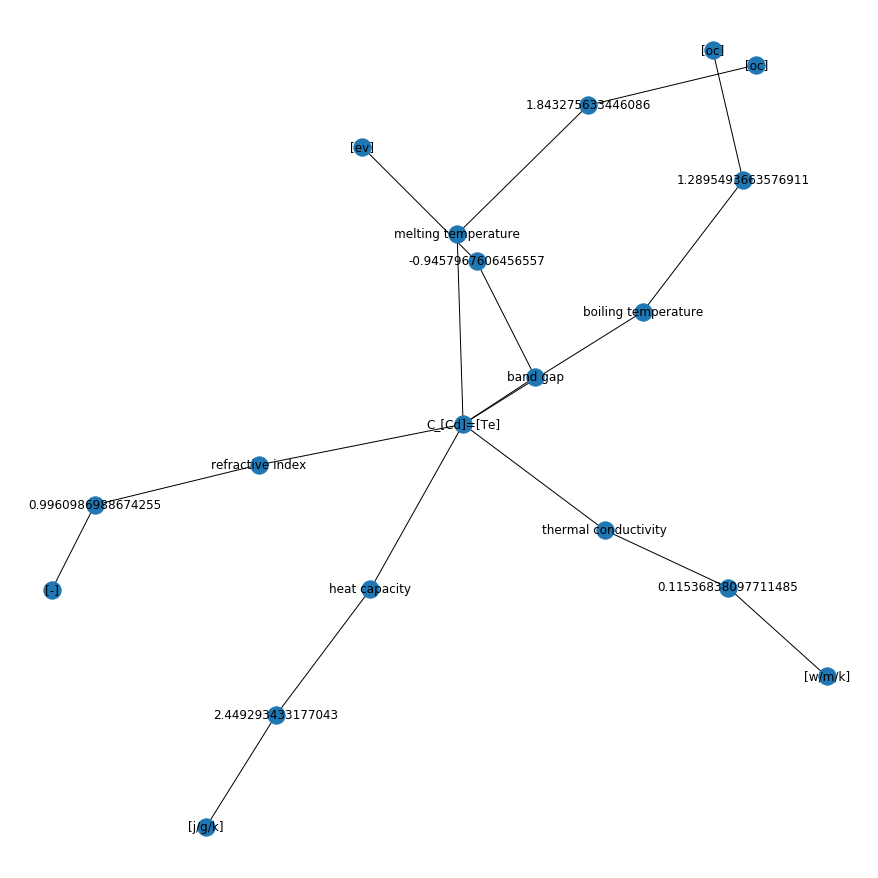

In [10]:
number=0

#draw
drawGraph(gList[number])
g=gList[number]
nodeVals=[g.nodes[node]["label"] for node in g.nodes]
nodeVals